In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import time
import torchvision
from torchvision import transforms
from torchvision import datasets
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available:
    device_name = torch.cuda.get_device_name(0)
    print(device_name)
print(f"Using device: {device}")

/home/csalitre/school/machine-learning/finance-models/.venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/csalitre/school/machine-learning/finance-models/.venv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


NVIDIA GeForce RTX 4050 Laptop GPU
Using device: cuda:0


In [2]:
# Load and transform the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the images
])

# Preprocessing
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# calculate trainable parameters
def model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [4]:
# Define a simplified AlexNet model for problem 1
class SimpleAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleAlexNet, self).__init__()
        # Convolutional Layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        feature_size = 32 * 32
        
        # Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(feature_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )


    def forward(self, x):
        # For debuggin purposes parse through each layer and print the size
        #for layer in self.features:
        #    print(x.size())  # Print the size after each layer in conv_layers
        #    x = layer(x)
        x = self.features(x)
        x = torch.flatten(x, 1) # Flatten the output
        x = self.classifier(x)
        return x
    


In [5]:
# Define train loop
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and targets to calculate accuracy
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
    

    avg_loss = total_loss / len(train_loader)
    train_accuracy = accuracy_score(all_targets, all_predictions)
    return avg_loss, train_accuracy


# Define the evaulation loop
def validate(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

        # Store predictions and targets to calculate accuracy
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    val_accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_targets, all_predictions)
    return avg_loss, val_accuracy, precision, cm

In [6]:
# PROBLEM 1
# Simplified AlexNet

# Instantiate model
model1 = SimpleAlexNet().to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

total_params, trainable_params = model_parameters(model1)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model1, train_loader, optimizer, loss_fn)
    val_loss, val_accuracy, precision, cm = validate(model1, val_loader, loss_fn)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}")
    #print("Confusion Matrix:\n", cm)

Total Parameters: 5294474
Trainable Parameters: 5294474
Epoch 1: Train Loss: 1.7652, Train Accuracy: 0.3195
Validation Loss: 1.4815, Validation Accuracy: 0.4375, Precision: 0.2639
Epoch 2: Train Loss: 1.3576, Train Accuracy: 0.5071
Validation Loss: 1.2284, Validation Accuracy: 0.7500, Precision: 0.6222
Epoch 3: Train Loss: 1.1742, Train Accuracy: 0.5830
Validation Loss: 1.1210, Validation Accuracy: 0.6250, Precision: 0.6111
Epoch 4: Train Loss: 1.0628, Train Accuracy: 0.6265
Validation Loss: 1.0599, Validation Accuracy: 0.5000, Precision: 0.4900
Epoch 5: Train Loss: 0.9613, Train Accuracy: 0.6628
Validation Loss: 1.0048, Validation Accuracy: 0.6875, Precision: 0.5741
Epoch 6: Train Loss: 0.8840, Train Accuracy: 0.6919
Validation Loss: 0.9261, Validation Accuracy: 0.5000, Precision: 0.3750
Epoch 7: Train Loss: 0.8167, Train Accuracy: 0.7134
Validation Loss: 0.9081, Validation Accuracy: 0.7500, Precision: 0.7222
Epoch 8: Train Loss: 0.7604, Train Accuracy: 0.7351
Validation Loss: 0.9029,

In [7]:
# Define Residual Network and Blocks

class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution
        
        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out

class ResNet10(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet10, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution
        
        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out
    

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution
        
        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, num_blocks[4], stride=2)
        self.layer6 = self._make_layer(block, 1024, num_blocks[5], stride=2)
        self.layer7 = self._make_layer(block, 2044, num_blocks[5], stride=2)
        self.layer8 = self._make_layer(block, 3024, num_blocks[5], stride=2)
        
        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out



Epoch 1, Training loss: 1.465928968566153, Validation loss: 1.210866862041935, Validation Accuracy: 58.11%
Epoch 2, Training loss: 0.908178162277507, Validation loss: 0.7285520134458117, Validation Accuracy: 74.49%
Epoch 3, Training loss: 0.6554092426815301, Validation loss: 0.7085936109351504, Validation Accuracy: 75.6%
Epoch 4, Training loss: 0.5047900278473754, Validation loss: 0.578869618617805, Validation Accuracy: 80.49%
Epoch 5, Training loss: 0.38063155141328, Validation loss: 0.6072533542563201, Validation Accuracy: 80.28%
Epoch 6, Training loss: 0.2651512696767402, Validation loss: 0.7737875446012825, Validation Accuracy: 78.4%
Epoch 7, Training loss: 0.18202680587063513, Validation loss: 0.7003997809188381, Validation Accuracy: 79.97%
Epoch 8, Training loss: 0.12223632746707182, Validation loss: 0.7625464878644154, Validation Accuracy: 80.82%
Epoch 9, Training loss: 0.09790826324359192, Validation loss: 0.7013660208055168, Validation Accuracy: 82.22%
Epoch 10, Training loss:

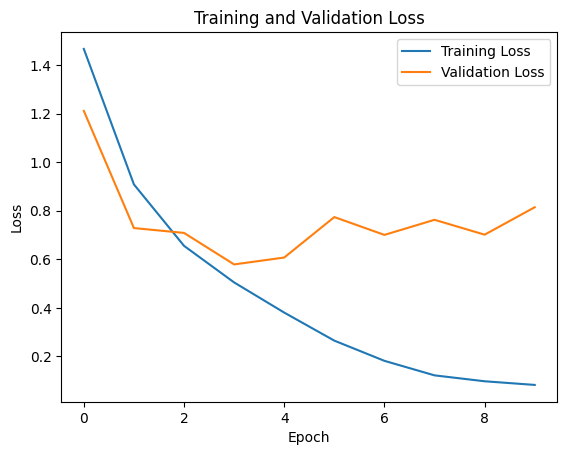

In [8]:
# Example of using the ResNet11 model
model2 = ResNet10(BasicBlock, [1, 1, 1, 1], num_classes=10)  # 4 blocks with 1 layer each
#print(model2)

# Define the network, loss function, and optimizer
net = model2.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/ResNet_training_validation_loss.png')
plt.show()

Epoch 1, Training loss: 1.5253734898079387, Validation loss: 1.1901184384989891, Validation Accuracy: 57.36%
Epoch 2, Training loss: 0.9774390047468493, Validation loss: 0.9219439724448381, Validation Accuracy: 67.61%
Epoch 3, Training loss: 0.7265176409879304, Validation loss: 0.7153765487063463, Validation Accuracy: 75.14%
Epoch 4, Training loss: 0.5560255346014676, Validation loss: 0.5887006642712149, Validation Accuracy: 79.62%
Epoch 5, Training loss: 0.4231899917849799, Validation loss: 0.6255901702650034, Validation Accuracy: 79.24%
Epoch 6, Training loss: 0.29265140152305286, Validation loss: 0.6724481444070294, Validation Accuracy: 79.18%
Epoch 7, Training loss: 0.19654804756364708, Validation loss: 0.6490545745488185, Validation Accuracy: 80.92%
Epoch 8, Training loss: 0.12702910304831727, Validation loss: 0.6992148815826246, Validation Accuracy: 81.2%
Epoch 9, Training loss: 0.10148495577318627, Validation loss: 0.9143931315203381, Validation Accuracy: 78.41%
Epoch 10, Traini

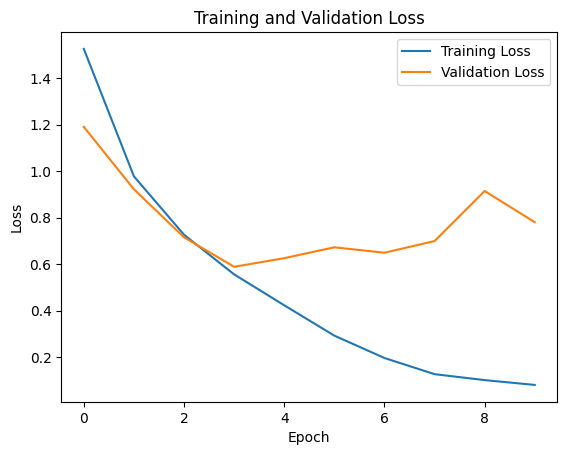

In [9]:
# Example of using the ResNet11 model
model3 = ResNet18(BasicBlock, [1, 1, 1, 1, 1, 1, 1, 1], num_classes=10)  # 8 blocks with 1 layer each
#print(model3)

# Define the network, loss function, and optimizer
net = model3.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/ResNet_training_validation_loss.png')
plt.show()